In [1]:
import numpy.random
import pandas as pd
import sqlite3
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
from sklearn.metrics.pairwise import haversine_distances
from math import radians

In [2]:
"""
Run parameters box.

The parameters defined in this section control some parts of the code:

@:param use_preComputed_hp - Indicator of whether or not use pre-found hyper-parameters for the prediction model. When set to 'False', Bayesian optimization will be performed.
"""
use_preComputed_hp = True  # whether or not to use the pre-found hyper-parameters for the model.

"""
Data files paths.

@:param  fires_train_path: path to fires train data.
@:param fires_test_path: path to fires test data.
@:param units_data_path: path to units data.

If 'fires_train_path' is set to None - the code will load the original data provided for the project ('FPA_FOD_20170508.sqlite') and split it automatically.
"""
fires_train_path = None
fires_test_path = None
units_data_path = None

"""
Prediction save indicators.

@:param save_test_prediction - saves the model's test prediction as a pandas Series, in a .pkl format.
@:param save_train_prediction - saves the model's train prediction as a pandas Series, in a .pkl format.

important note - the prediction values are the same values as in the 'STAT_CAUSE_DESCR'.
"""
save_test_prediction = False
save_train_prediction = False

In [3]:
def read_data(data_path: str) -> callable:
    """
    This function handles the reading of a single data file.
    """
    if data_path[-4: ] == '.csv':
        return pd.read_csv(data_path, index_col=None)

    raise ValueError(f"invalid input: {data_path}, input tables can be .csv only")

### Loading the data ###
***
In this section, we load the data, stored in 2 different tables: "fires" and "NWCG_UnitIDActive_20170109".

The goal here is to integrate information regarding the reporting units into the fires data.

In [4]:
if fires_train_path is None:
    conn = sqlite3.connect('FPA_FOD_20170508.sqlite')
    fires_df = pd.read_sql_query("SELECT * from Fires ", conn)  # fires table
    units_df = pd.read_sql_query("SELECT * from NWCG_UnitIDActive_20170109 ", conn)  # units table
else:
    fires_train_df = read_data(fires_train_path)
    fires_test_df = read_data(fires_test_path)
    units_df = read_data(units_data_path)

    fires_df = pd.concat([fires_train_df, fires_test_df])

parks_data = pd.read_csv('states_parks.csv')

In [5]:
fires_df.head()

,OBJECTID,FOD_ID,FPA_ID,SOURCE_SYSTEM_TYPE,SOURCE_SYSTEM,NWCG_REPORTING_AGENCY,NWCG_REPORTING_UNIT_ID,NWCG_REPORTING_UNIT_NAME,SOURCE_REPORTING_UNIT,SOURCE_REPORTING_UNIT_NAME,...,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,OWNER_CODE,OWNER_DESCR,STATE,COUNTY,FIPS_CODE,FIPS_NAME,Shape
0,463445,497959,SFO-ID0043_3101998026,NONFED,ST-NASF,ST/C&L,USIDIDS,Idaho Department of Lands,ID310,IDS District 310,...,B,47.600845,-116.306789,14.0,MISSING/NOT SPECIFIED,ID,Kootenai,055,Kootenai,b'\x00\x01\xad\x10\x00\x00pqTn\xa2\x13]\xc0\x9...
1,1464479,201104109,W-626311,FED,DOI-WFMI,BIA,USMTFBA,Fort Belknap Agency,MTFBA,Fort Belknap Agency,...,A,48.403300,-108.289600,8.0,PRIVATE,MT,None,None,None,b'\x00\x01\xad\x10\x00\x00\xf8:p\xce\x88\x12[\...
2,1591094,201608816,SFO-NE-2012-16029,NONFED,ST-NASF,ST/C&L,USNENES,Nebraska Department of Forestry,NENFS,Nebraska Forest Service,...,B,40.668460,-99.089130,14.0,MISSING/NOT SPECIFIED,NE,None,None,None,b'\x00\x01\xad\x10\x00\x00\xe8\xc5PN\xb4\xc5X\...
3,944726,1072277,SWRA_VA_11300,NONFED,ST-VAVAS,ST/C&L,USVAVAS,Virginia Department of Forestry,VAVAS3,Farmville District,...,B,39.000000,-78.269200,14.0,MISSING/NOT SPECIFIED,VA,None,None,None,b'\x00\x01\xad\x10\x00\x00P\x05\xa3\x92:\x91S\...
4,896277,1022153,SWRA_LA_24392,NONFED,ST-LALAS,ST/C&L,USLALAS,Louisiana Office of Forestry,LALAS1,LAS District 1,...,B,30.993300,-89.863900,14.0,MISSING/NOT SPECIFIED,LA,None,None,None,b'\x00\x01\xad\x10\x00\x00\xe8\xc09#JwV\xc0\xf...


In [6]:
# preparing the units df to merge with the fires data
units_df.drop('OBJECTID', axis=1, inplace=True)
units_df.rename(mapper={'UnitId': 'NWCG_REPORTING_UNIT_ID'}, axis=1, inplace=True)

units_df.head()

,NWCG_REPORTING_UNIT_ID,GeographicArea,Gacc,WildlandRole,UnitType,Department,Agency,Parent,Country,State,Code,Name
0,USAKCAN,AK,USAKACC,Resource Provider Only,Non-Government,NG,ANC,None,US,AK,CAN,Calista Regional Native Corporation
1,USAKCEKX,AK,USAKACC,Incident Host Geographic,US County/Local,AK,C&L,None,US,AK,CEKX,Central Emergency Services
2,USAKCFFX,AK,USAKACC,Incident Host Geographic,US County/Local,AK,C&L,None,US,AK,CFFX,City Fairbanks Fire Department
3,USAKCFMX,AK,USAKACC,Incident Host Geographic,US County/Local,AK,C&L,None,US,AK,CFMX,Central Mat-Su Fire Department
4,USAKCFQ,AK,USAKACC,Incident Host Geographic,US Federal,DOD,USAF,None,US,AK,CFQ,Clear Air Force Station


In [7]:
# plugging the unit data to fires data
data_df = fires_df.merge(units_df, how='left', on='NWCG_REPORTING_UNIT_ID')
data_df = data_df.loc[:, ['OBJECTID','LATITUDE', 'LONGITUDE', 'SOURCE_SYSTEM_TYPE', 'FIRE_YEAR', 'FIRE_SIZE', 'DISCOVERY_DOY', 'OWNER_CODE', 'Gacc', 'UnitType','STATE', 'NWCG_REPORTING_UNIT_ID', 'DISCOVERY_DATE', 'STAT_CAUSE_DESCR']]

data_df.head()

,OBJECTID,LATITUDE,LONGITUDE,SOURCE_SYSTEM_TYPE,FIRE_YEAR,FIRE_SIZE,DISCOVERY_DOY,OWNER_CODE,Gacc,UnitType,STATE,NWCG_REPORTING_UNIT_ID,DISCOVERY_DATE,STAT_CAUSE_DESCR
0,463445,47.600845,-116.306789,NONFED,1998,2.0,260,14.0,USUTGBC,US State,ID,USIDIDS,2451073.5,Missing/Undefined
1,1464479,48.403300,-108.289600,FED,2011,0.1,234,8.0,USMTNRC,US Federal,MT,USMTFBA,2455795.5,Miscellaneous
2,1591094,40.668460,-99.089130,NONFED,2012,1.5,140,14.0,USCORMC,US State,NE,USNENES,2456066.5,Miscellaneous
3,944726,39.000000,-78.269200,NONFED,2002,2.0,4,14.0,USGASAC,US State,VA,USVAVAS,2452278.5,Miscellaneous
4,896277,30.993300,-89.863900,NONFED,2002,5.0,136,14.0,USGASAC,US State,LA,USLALAS,2452410.5,Arson


In [8]:
# saving gacc data for later
gacc_df = data_df.loc[:, ['OBJECTID', 'Gacc', 'LATITUDE', 'LONGITUDE']]
gacc_df.set_index('OBJECTID', inplace=True)

### Adding weather data ###
***
In this section we integrate weather data into our fires data set. To do so, we used a python package named 'meteostat'.

The 'meteostat' package allows us to access daily weather measurements data of hundreds of weather stations spread around the United States. For each station, we can it's daily measurements in a certain year.

So, in order to obtain weather data that is compatible with our current fires data, we applied the following procedure:
1. Obtained a list of all the weather stations in the U.S. , along with their unique id values, elevation level (in meters), latitude and longitude.
2. Obtained past daily measurements for each station for the years 1992 - 2015 (all the years in the fires dataset).
3. For each fire in the fires data, we assigned a station based on geographic proximity (computed using coordinates).
4. After assigning a station to each fire, we plugged the matching weather data based on the matching station and date.

Important notes:
* Regarding stage 2: for some days, the requested data was missing. in such cases, we used linear interpolation (builtin pandas function) to fill measurements data. Also, for some stations, the requested data was not available at all - in such case, the station was removed from consideration.
* Regarding stage 3: the geographic proximity was determined by computing the Haversine distance between the fires coordinates and the stations coordinates. Particularly, we converted the LATITUDE and LONGITUDE to radians, and computed the Haversine distance: $D\left(x,y\right)=2\cdot arcsin\left[\sqrt{sin^{2}\left(\left(x_{1}-y_{1}\right)\slash2\right)+cos\left(x_{1}\right)cos\left(y_{1}\right)sin^{2}\left(\left(x_{2}-y_{2}\right)\slash2\right)}\right]$

In [9]:
weather_data = pd.read_pickle('met_data_clean.pkl')
stations_df = pd.read_pickle('stations_df_clean.pkl')

The weather data contains past measurements as follows:

In [10]:
weather_data.head()

,time,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun,station_id,month,year
0,1992-01-01,14.0,6.7,20.6,0.0,0.0,101.66514,4.7,18.4,1017.60,NaN,69014,1,1992
1,1992-01-02,16.9,12.2,25.0,0.0,0.0,101.66514,5.4,25.9,1013.20,NaN,69014,1,1992
2,1992-01-03,13.7,11.1,15.6,6.9,0.0,101.66514,4.3,20.5,1012.55,NaN,69014,1,1992
3,1992-01-04,14.8,11.1,19.4,0.0,0.0,101.66514,2.2,13.0,1011.90,NaN,69014,1,1992
4,1992-01-05,12.6,10.0,15.0,30.7,0.0,101.66514,12.2,53.6,1007.70,NaN,69014,1,1992


The stations data contains weather stations information as follows:

In [11]:
stations_df.head()

,name,country,region,wmo,icao,latitude,longitude,elevation,timezone,hourly_start,hourly_end,daily_start,daily_end,monthly_start,monthly_end,latitude_radians,longitude_radians
id,,,,,,,,,,,,,,,,,
69014,Irvine,US,CA,69014,KNZJ,33.6667,-117.7167,119.0,America/Los_Angeles,1989-01-01,1999-06-06,1945-03-01,1998-12-10,1945-01-01,1998-01-01,0.587595,-2.054544
69015,Twentynine Palms / Sunfair Heights,US,CA,69015,KNXP,34.2962,-116.1622,625.0,America/Los_Angeles,1990-01-02,2023-02-21,1945-05-01,2022-04-24,1945-01-01,2021-01-01,0.598582,-2.027413
69023,Whidbey Island / Ault Field,US,WA,69023,KNUW,48.3518,-122.6560,14.0,America/Los_Angeles,2005-01-01,2023-02-20,1945-04-01,2022-04-24,1945-01-01,2022-01-01,0.843898,-2.140751
70026,Post Rogers Memorial Airport,US,AK,70026,PABR,71.2833,-156.7667,13.0,America/Juneau,1945-01-01,2023-02-21,1901-09-01,2023-02-16,1901-01-01,2022-01-01,1.244128,-2.736095
70133,Wien Memorial Airport,US,AK,70133,PAOT,66.8833,-162.6000,3.0,America/Nome,1973-01-01,2023-02-21,1897-09-12,2023-02-16,1897-01-01,2022-01-01,1.167334,-2.837905


In [12]:
weather_data['merge_col'] = weather_data['time'].apply(lambda x: x.strftime('%Y-%m-%d'))
weather_data['merge_col'] = list(zip(weather_data.station_id, weather_data.merge_col))

In [13]:
weather_data.set_index('merge_col', inplace=True)
weather_data.reset_index(None, inplace=True)

In [14]:
# creating weather table indexed by fires OBJECTID
met_data = fires_df.loc[:, ['LATITUDE', 'LONGITUDE', 'DISCOVERY_DATE', 'OBJECTID']]
met_data['DISCOVERY_DATE'] = pd.to_datetime(met_data['DISCOVERY_DATE'] - pd.Timestamp(0).to_julian_date(), unit='D')

met_data.head()

,LATITUDE,LONGITUDE,DISCOVERY_DATE,OBJECTID
0,47.600845,-116.306789,1998-09-17,463445
1,48.403300,-108.289600,2011-08-22,1464479
2,40.668460,-99.089130,2012-05-19,1591094
3,39.000000,-78.269200,2002-01-04,944726
4,30.993300,-89.863900,2002-05-16,896277


In [15]:
# clipping year to fit the range 1992-2015
def clip_discovery_year(cur_time: pd.Timestamp):
    if cur_time.year in range(1992, 2016):
        return cur_time

    clipped_year = int(np.clip(cur_time.year, a_min=1992, a_max=2015) )

    try:
        return cur_time.replace(year=clipped_year)
    except ValueError:
        return pd.Timestamp(day=1, month=1, year=clipped_year)

In [16]:
met_data['DISCOVERY_DATE'] = met_data['DISCOVERY_DATE'].apply(clip_discovery_year)

In [17]:
# converting met_data coordinates to radians
met_data['LATITUDE'] = met_data['LATITUDE'].apply(radians)
met_data['LONGITUDE'] = met_data['LONGITUDE'].apply(radians)

met_data.head()

,LATITUDE,LONGITUDE,DISCOVERY_DATE,OBJECTID
0,0.830791,-2.029936,1998-09-17,463445
1,0.844797,-1.890010,2011-08-22,1464479
2,0.709799,-1.729432,2012-05-19,1591094
3,0.680678,-1.366055,2002-01-04,944726
4,0.540935,-1.568421,2002-05-16,896277


In [18]:
met_data.set_index('OBJECTID', inplace=True)

In [19]:
# computing the haversine distance between fires and stations
dist_matrix = haversine_distances(met_data.loc[:, ['LATITUDE', 'LONGITUDE']], stations_df.loc[:, ['latitude_radians', 'longitude_radians']])
dist_matrix = pd.DataFrame(data=dist_matrix, index=met_data.index, columns=stations_df.index)

In [20]:
# assigning a station id to fire OBJECTID by coordinates proximity
met_data['station_id'] = dist_matrix.idxmin(axis=1)

met_data.head()

,LATITUDE,LONGITUDE,DISCOVERY_DATE,station_id
OBJECTID,,,,
463445,0.830791,-2.029936,1998-09-17,72785
1464479,0.844797,-1.890010,2011-08-22,72768
1591094,0.709799,-1.729432,2012-05-19,72552
944726,0.680678,-1.366055,2002-01-04,72403
896277,0.540935,-1.568421,2002-05-16,72231


In [21]:
# merging the weather data into
met_data['merge_col'] = met_data['DISCOVERY_DATE'].apply(lambda x: x.strftime('%Y-%m-%d'))
met_data['merge_col'] = list(zip(met_data.station_id, met_data.merge_col))

met_data.head()

,LATITUDE,LONGITUDE,DISCOVERY_DATE,station_id,merge_col
OBJECTID,,,,,
463445,0.830791,-2.029936,1998-09-17,72785,"(72785, 1998-09-17)"
1464479,0.844797,-1.890010,2011-08-22,72768,"(72768, 2011-08-22)"
1591094,0.709799,-1.729432,2012-05-19,72552,"(72552, 2012-05-19)"
944726,0.680678,-1.366055,2002-01-04,72403,"(72403, 2002-01-04)"
896277,0.540935,-1.568421,2002-05-16,72231,"(72231, 2002-05-16)"


In [22]:
# adding elevation data
met_data['elevation'] = met_data['station_id'].apply(lambda x: stations_df.loc[x, 'elevation'])

met_data.head()

,LATITUDE,LONGITUDE,DISCOVERY_DATE,station_id,merge_col,elevation
OBJECTID,,,,,,
463445,0.830791,-2.029936,1998-09-17,72785,"(72785, 1998-09-17)",723.0
1464479,0.844797,-1.890010,2011-08-22,72768,"(72768, 2011-08-22)",699.0
1591094,0.709799,-1.729432,2012-05-19,72552,"(72552, 2012-05-19)",563.0
944726,0.680678,-1.366055,2002-01-04,72403,"(72403, 2002-01-04)",95.0
896277,0.540935,-1.568421,2002-05-16,72231,"(72231, 2002-05-16)",2.0


In [23]:
met_data.reset_index(None, inplace=True)
met_data = met_data.merge(weather_data, how='left', on='merge_col')
met_data.set_index('OBJECTID', inplace=True)

met_data.head()

,LATITUDE,LONGITUDE,DISCOVERY_DATE,station_id_x,merge_col,elevation,time,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun,station_id_y,month,year
OBJECTID,,,,,,,,,,,,,,,,,,,,
463445,0.830791,-2.029936,1998-09-17,72785,"(72785, 1998-09-17)",723.0,1998-09-17,19.4,13.3,25.6,0.5,0.0,138.000000,12.6,25.9,1007.0,150.608696,72785,9.0,1998.0
1464479,0.844797,-1.890010,2011-08-22,72768,"(72768, 2011-08-22)",699.0,2011-08-22,25.3,13.3,36.1,0.0,0.0,30.750000,10.8,27.7,1005.6,0.000000,72768,8.0,2011.0
1591094,0.709799,-1.729432,2012-05-19,72552,"(72552, 2012-05-19)",563.0,2012-05-19,20.8,12.8,26.7,9.7,0.0,163.333333,24.1,24.1,1012.3,0.000000,72552,5.0,2012.0
944726,0.680678,-1.366055,2002-01-04,72403,"(72403, 2002-01-04)",95.0,2002-01-04,-0.6,-6.7,5.0,0.0,0.0,310.285714,15.1,48.2,1020.3,0.000000,72403,1.0,2002.0
896277,0.540935,-1.568421,2002-05-16,72231,"(72231, 2002-05-16)",2.0,2002-05-16,25.6,20.6,30.6,0.0,0.0,143.000000,14.8,44.3,1018.3,0.000000,72231,5.0,2002.0


In [24]:
weather_keep_cols = ['elevation', 'tavg', 'tmin', 'tmax', 'prcp', 'snow', 'wdir', 'wspd', 'wpgt','station_id_x', 'month', 'year']

In [25]:
met_data = met_data.loc[:, weather_keep_cols]

met_data.head()

,elevation,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,station_id_x,month,year
OBJECTID,,,,,,,,,,,,
463445,723.0,19.4,13.3,25.6,0.5,0.0,138.000000,12.6,25.9,72785,9.0,1998.0
1464479,699.0,25.3,13.3,36.1,0.0,0.0,30.750000,10.8,27.7,72768,8.0,2011.0
1591094,563.0,20.8,12.8,26.7,9.7,0.0,163.333333,24.1,24.1,72552,5.0,2012.0
944726,95.0,-0.6,-6.7,5.0,0.0,0.0,310.285714,15.1,48.2,72403,1.0,2002.0
896277,2.0,25.6,20.6,30.6,0.0,0.0,143.000000,14.8,44.3,72231,5.0,2002.0


So the processed weather data is stored in the 'met_data' dataframe, which is indexed by the fires' 'OBJECTID' and is formatted as follows:

In [26]:
met_data.head()

,elevation,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,station_id_x,month,year
OBJECTID,,,,,,,,,,,,
463445,723.0,19.4,13.3,25.6,0.5,0.0,138.000000,12.6,25.9,72785,9.0,1998.0
1464479,699.0,25.3,13.3,36.1,0.0,0.0,30.750000,10.8,27.7,72768,8.0,2011.0
1591094,563.0,20.8,12.8,26.7,9.7,0.0,163.333333,24.1,24.1,72552,5.0,2012.0
944726,95.0,-0.6,-6.7,5.0,0.0,0.0,310.285714,15.1,48.2,72403,1.0,2002.0
896277,2.0,25.6,20.6,30.6,0.0,0.0,143.000000,14.8,44.3,72231,5.0,2002.0


In [27]:
# plugging the weather data to the fires data
data_df = data_df.merge(met_data, how='left', on='OBJECTID')

data_df.head()

,OBJECTID,LATITUDE,LONGITUDE,SOURCE_SYSTEM_TYPE,FIRE_YEAR,FIRE_SIZE,DISCOVERY_DOY,OWNER_CODE,Gacc,UnitType,...,tmin,tmax,prcp,snow,wdir,wspd,wpgt,station_id_x,month,year
0,463445,47.600845,-116.306789,NONFED,1998,2.0,260,14.0,USUTGBC,US State,...,13.3,25.6,0.5,0.0,138.000000,12.6,25.9,72785,9.0,1998.0
1,1464479,48.403300,-108.289600,FED,2011,0.1,234,8.0,USMTNRC,US Federal,...,13.3,36.1,0.0,0.0,30.750000,10.8,27.7,72768,8.0,2011.0
2,1591094,40.668460,-99.089130,NONFED,2012,1.5,140,14.0,USCORMC,US State,...,12.8,26.7,9.7,0.0,163.333333,24.1,24.1,72552,5.0,2012.0
3,944726,39.000000,-78.269200,NONFED,2002,2.0,4,14.0,USGASAC,US State,...,-6.7,5.0,0.0,0.0,310.285714,15.1,48.2,72403,1.0,2002.0
4,896277,30.993300,-89.863900,NONFED,2002,5.0,136,14.0,USGASAC,US State,...,20.6,30.6,0.0,0.0,143.000000,14.8,44.3,72231,5.0,2002.0


In [28]:
# storing the months and years for imputation
data_df['month'] = pd.to_datetime(data_df['DISCOVERY_DATE'] - pd.Timestamp(0).to_julian_date(), unit='D')
data_df['year'] = pd.to_datetime(data_df['DISCOVERY_DATE'] - pd.Timestamp(0).to_julian_date(), unit='D')

data_df['month'] = data_df['month'].apply(lambda x: x.month)
data_df['year'] = data_df['year'].apply(lambda x: x.year)

### Adding parks data ###
***
For each state in the data, we add the number of national parks in that state.

The mentioned information was taken from wikipedia and stored in a .csv file, formatted as follows:

In [29]:
parks_data.head()

,STATE,Total parks
0,CA,9
1,AK,8
2,UT,5
3,CO,4
4,AZ,3


In [30]:
data_df = data_df.merge(parks_data, how='left', on='STATE')
data_df['Total parks'] = data_df['Total parks'].fillna(0)

data_df.head()

,OBJECTID,LATITUDE,LONGITUDE,SOURCE_SYSTEM_TYPE,FIRE_YEAR,FIRE_SIZE,DISCOVERY_DOY,OWNER_CODE,Gacc,UnitType,...,tmax,prcp,snow,wdir,wspd,wpgt,station_id_x,month,year,Total parks
0,463445,47.600845,-116.306789,NONFED,1998,2.0,260,14.0,USUTGBC,US State,...,25.6,0.5,0.0,138.000000,12.6,25.9,72785,9,1998,1.0
1,1464479,48.403300,-108.289600,FED,2011,0.1,234,8.0,USMTNRC,US Federal,...,36.1,0.0,0.0,30.750000,10.8,27.7,72768,8,2011,2.0
2,1591094,40.668460,-99.089130,NONFED,2012,1.5,140,14.0,USCORMC,US State,...,26.7,9.7,0.0,163.333333,24.1,24.1,72552,5,2012,0.0
3,944726,39.000000,-78.269200,NONFED,2002,2.0,4,14.0,USGASAC,US State,...,5.0,0.0,0.0,310.285714,15.1,48.2,72403,1,2002,1.0
4,896277,30.993300,-89.863900,NONFED,2002,5.0,136,14.0,USGASAC,US State,...,30.6,0.0,0.0,143.000000,14.8,44.3,72231,5,2002,0.0


### Handling missing values ###
***
Let us explore quantity of missing values for each feature:

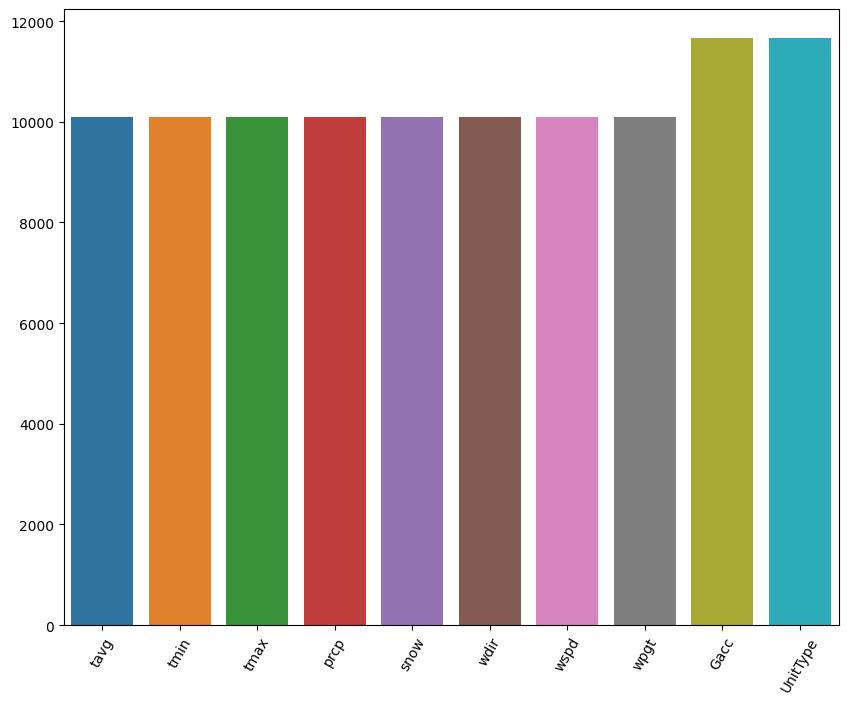

In [31]:
na_cols = {}
na_count = 0

for col_name in data_df.columns:
    na_count = data_df[col_name].isna().sum()

    if na_count > 0:
        na_cols.update({col_name: na_count})

na_count_df = pd.Series(na_cols).sort_values()

fig, ax = plt.subplots(figsize=(10,8))
ax.tick_params(rotation=60, axis='x')

try:
    sns.barplot(x=na_count_df.index, y=na_count_df, ax=ax)
except Exception:
    print(na_count_df)

As visible in the above plot, missing values exist in the weather cols, as well as in the 'UnitType' and 'Gacc'.

It is important to note that the imputation is done separately on the train and test sets to avoid information leakage. Hence, as a first step - we split the data to train and test sets. In a later stage, when we process the Categorical data using one-hot encoding we would want to use the full data to avoid feature mismatch between the train and test sets. Having said that, we wish to stress out that the train and test sets are determined only once and only in this section. Even if we use the full data in later stages, we do so in a leakage-safe manner, where the train and test sets contain the same samples throughout the entire process.

First, we deal with the missing values in the 'Gacc' column:

In [32]:
data_df.set_index('OBJECTID', inplace=True)

In [33]:
from sklearn.model_selection import train_test_split

if fires_train_path is None:
    train_data, test_data = train_test_split(data_df, test_size=0.25, stratify=data_df[['STAT_CAUSE_DESCR']])
else:
    fires_train_df.set_index('OBJECTID', inplace=True)
    fires_test_df.set_index('OBJECTID', inplace=True)

    train_data = data_df.loc[fires_train_df.index, :]
    test_data = data_df.loc[fires_test_df.index, :]

train_ind = train_data.index

Recall that the 'Gacc' column contains unique codes for geographic areas in the U.S.

Hence, after splitting the data to train and test sets, we use the train data to compute the mean LATITUDE and LONGITUDE for each 'Gacc' code - thus, obtaining the 'center' of each 'Gacc':

In [34]:
gacc_df = gacc_df.loc[train_ind, :].groupby('Gacc').mean()

gacc_df

,LATITUDE,LONGITUDE
Gacc,,
USAKACC,62.984958,-149.181153
USCAONCC,39.712788,-122.049203
USCAOSCC,35.537914,-118.737793
USCORMC,41.428377,-103.464932
USGASAC,33.000264,-86.657697
USMTNRC,47.194975,-110.015555
USNMSWC,34.232093,-109.506430
USORNWC,45.145643,-120.870582
USUTGBC,40.866351,-113.934003


Following similar logic as before, we convert the coordinates to radians and compute the Haversine distance between the above centers and the coordinates of the fires with missing 'Gacc' values:
#### $D\left(x,y\right)=2\cdot arcsin\left[\sqrt{sin^{2}\left(\left(x_{1}-y_{1}\right)\slash2\right)+cos\left(x_{1}\right)cos\left(y_{1}\right)sin^{2}\left(\left(x_{2}-y_{2}\right)\slash2\right)}\right]$ ####

In [35]:
from math import radians
gacc_df['LATITUDE'] = gacc_df['LATITUDE'].apply(radians)
gacc_df['LONGITUDE'] = gacc_df['LONGITUDE'].apply(radians)

gacc_df

,LATITUDE,LONGITUDE
Gacc,,
USAKACC,1.099295,-2.603702
USCAONCC,0.693119,-2.130160
USCAOSCC,0.620254,-2.072365
USCORMC,0.723062,-1.805804
USGASAC,0.575963,-1.512462
USMTNRC,0.823708,-1.920134
USNMSWC,0.597463,-1.911248
USORNWC,0.787940,-2.109590
USUTGBC,0.713252,-1.988523


After computing the distances between the fires and the centers, we match each fire with missing 'Gacc' with the 'Gacc' who's center is of the highest proximity to the fire.

<U> important note: </U> the 'Gacc' centers mentioned above are computed only for the train data, to avoid potential information leakage from the test set to the train set. However, the imputation based on the centers is done on the entire (unsplit) data for convenience and consistency reasons. As the information upon the imputation relies is computed for train samples only, we can be certain the no such leakage occurs here.

In [36]:
from sklearn.metrics.pairwise import haversine_distances

def fill_gacc(cur_df: pd.DataFrame):
    sub_df = cur_df.loc[:, ['LATITUDE', 'LONGITUDE', 'Gacc']]
    sub_df = sub_df.loc[sub_df['Gacc'].isna(), :]

    sub_df['LATITUDE'] = sub_df['LATITUDE'].apply(radians)
    sub_df['LONGITUDE'] = sub_df['LONGITUDE'].apply(radians)

    dist_matrix = haversine_distances(sub_df.loc[:, ['LATITUDE', 'LONGITUDE']], gacc_df)
    dist_matrix = pd.DataFrame(data=dist_matrix, index=sub_df.index, columns=gacc_df.index)

    # filling the missing values
    cur_df.loc[sub_df.index, 'Gacc'] = pd.Series(data=dist_matrix.idxmin(axis=1))

In [37]:
fill_gacc(data_df)

Now, after imputing the 'Gacc' column, we proceed to impute the 'UnitType' column.

Note that here as well, the imputation values are computed solely based on the train samples.

The imputation for this column is done as follows:
1. we compute the relative frequency of each 'UnitType' in the train set and obtain a frequency vector.
2. Let $m\in\mathbb{N}$ be the number of samples with missing 'UnitType' value. So, we generate a random list of 'UnitType' values of size $m$ and with probabilities matching the frequency vector found in stage1.
3. Finally, we assign the relevant samples with the random 'UnitType' values obtained in stage 2.

In [38]:
# filling the unit types
unit_type_probs = train_data['UnitType'].groupby(train_data['UnitType']).count() / train_data['UnitType'].count()

unit_type_probs

UnitType
Interagency        0.000030
Tribe              0.001903
US County/Local    0.046690
US Federal         0.260519
US State           0.690858
Name: UnitType, dtype: float64

In [39]:
missing_unit_type_ind = data_df.loc[data_df['UnitType'].isna(), 'UnitType'].index
unit_fill_sr = pd.Series(data=np.random.choice(unit_type_probs.index, size=data_df['UnitType'].isna().sum(), p=unit_type_probs), index=missing_unit_type_ind)

data_df.loc[missing_unit_type_ind, 'UnitType'] = unit_fill_sr

Now, we impute the weather data.

we do so by aggregating the <U>train data</U> by ('STATE', 'month') pairs, we fill the missing values.

In [40]:
weather_cols = ['tavg', 'tmin', 'tmax', 'prcp', 'snow', 'wdir', 'wspd', 'wpgt']

In [41]:
state_weather_agg = train_data.groupby(['STATE', 'month']).mean()

for cur_weather_col in weather_cols:
    sub_df = data_df.loc[data_df[cur_weather_col].isna(), ['STATE', 'month', cur_weather_col]]
    sub_df[cur_weather_col] = list(zip(sub_df.STATE, sub_df.month))

    try:
        sub_df[cur_weather_col] = sub_df[cur_weather_col].apply(lambda x: state_weather_agg.loc[x, cur_weather_col])
    except KeyError:
        continue

    data_df.loc[sub_df.index, cur_weather_col] = sub_df.loc[sub_df.index, cur_weather_col]

    print(f"imputed column {cur_weather_col}")

imputed column tavg
imputed column tmin
imputed column tmax
imputed column prcp
imputed column snow
imputed column wdir
imputed column wspd
imputed column wpgt


In [42]:
for cur_weather_col in weather_cols:
    print(f"col = {cur_weather_col} ; missing values count = {data_df[cur_weather_col].isna().sum()}")

col = tavg ; missing values count = 0
col = tmin ; missing values count = 0
col = tmax ; missing values count = 0
col = prcp ; missing values count = 0
col = snow ; missing values count = 0
col = wdir ; missing values count = 0
col = wspd ; missing values count = 0
col = wpgt ; missing values count = 0


In [43]:
# handling any other missing values in the data, by assigning the mode
for cur_col in data_df.columns:
    try:
        data_df.loc[data_df[cur_col].isna(), cur_col] = train_data[cur_col].mode().item()
    except ValueError:
        data_df.loc[data_df[cur_col].isna(), cur_col] = 0

In [44]:
for cur_weather_col in weather_cols:
    print(f"col = {cur_weather_col} ; missing values count = {data_df[cur_weather_col].isna().sum()}")

col = tavg ; missing values count = 0
col = tmin ; missing values count = 0
col = tmax ; missing values count = 0
col = prcp ; missing values count = 0
col = snow ; missing values count = 0
col = wdir ; missing values count = 0
col = wspd ; missing values count = 0
col = wpgt ; missing values count = 0


### Adding aggregate features ###
***
Let us add the following aggregate features:
1. Average number of acres (FIRE_SIZE) consumed by wildfire per Gacc, per year.
2. Number of fires per Gacc per year
3. Number of fires per reporting unit
4. Average temperature per Gacc per year

Again, note that the aggregation is done solely on the train data, and only then assigned to the entire (unsplit data). This is done for convenience and consistency reasons as we wish to use the full data in a later stage. So still, no risk of leakage here.

In [45]:
# aggregating by average acres per Gacc per year
agg_df = train_data.groupby(['Gacc', 'FIRE_YEAR']).mean().loc[:, 'FIRE_SIZE']

agg_df

Gacc      FIRE_YEAR
USAKACC   1992         440.398814
          1993         187.939152
          1994         308.063574
          1995         172.150761
          1996         897.897759
                          ...    
USWIEACC  2011          19.002385
          2012           8.572208
          2013           6.487679
          2014           6.438705
          2015           6.625270
Name: FIRE_SIZE, Length: 240, dtype: float64

In [46]:
data_df['fire_size_mean'] = list(zip(data_df.Gacc, data_df.FIRE_YEAR))
data_df['fire_size_mean'] = data_df['fire_size_mean'].apply(lambda x: agg_df.loc[x])

data_df.head()

,LATITUDE,LONGITUDE,SOURCE_SYSTEM_TYPE,FIRE_YEAR,FIRE_SIZE,DISCOVERY_DOY,OWNER_CODE,Gacc,UnitType,STATE,...,prcp,snow,wdir,wspd,wpgt,station_id_x,month,year,Total parks,fire_size_mean
OBJECTID,,,,,,,,,,,,,,,,,,,,,
463445,47.600845,-116.306789,NONFED,1998,2.0,260,14.0,USUTGBC,US State,ID,...,0.5,0.0,138.000000,12.6,25.9,72785,9,1998,1.0,94.659654
1464479,48.403300,-108.289600,FED,2011,0.1,234,8.0,USMTNRC,US Federal,MT,...,0.0,0.0,30.750000,10.8,27.7,72768,8,2011,2.0,101.710737
1591094,40.668460,-99.089130,NONFED,2012,1.5,140,14.0,USCORMC,US State,NE,...,9.7,0.0,163.333333,24.1,24.1,72552,5,2012,0.0,96.368654
944726,39.000000,-78.269200,NONFED,2002,2.0,4,14.0,USGASAC,US State,VA,...,0.0,0.0,310.285714,15.1,48.2,72403,1,2002,1.0,12.023816
896277,30.993300,-89.863900,NONFED,2002,5.0,136,14.0,USGASAC,US State,LA,...,0.0,0.0,143.000000,14.8,44.3,72231,5,2002,0.0,12.023816


In [47]:
# aggregating by count of fires per Gacc per year
agg_df = train_data.reset_index(None).groupby(['Gacc', 'FIRE_YEAR']).count().loc[:, 'OBJECTID']

agg_df

Gacc      FIRE_YEAR
USAKACC   1992          253
          1993          401
          1994          291
          1995          197
          1996          357
                       ... 
USWIEACC  2011         2303
          2012         3338
          2013         2275
          2014         3043
          2015         4171
Name: OBJECTID, Length: 240, dtype: int64

In [48]:
data_df['fire_gacc_count'] = list(zip(data_df.Gacc, data_df.FIRE_YEAR))
data_df['fire_gacc_count'] = data_df['fire_gacc_count'].apply(lambda x: agg_df.loc[x])

data_df.head()

,LATITUDE,LONGITUDE,SOURCE_SYSTEM_TYPE,FIRE_YEAR,FIRE_SIZE,DISCOVERY_DOY,OWNER_CODE,Gacc,UnitType,STATE,...,snow,wdir,wspd,wpgt,station_id_x,month,year,Total parks,fire_size_mean,fire_gacc_count
OBJECTID,,,,,,,,,,,,,,,,,,,,,
463445,47.600845,-116.306789,NONFED,1998,2.0,260,14.0,USUTGBC,US State,ID,...,0.0,138.000000,12.6,25.9,72785,9,1998,1.0,94.659654,722
1464479,48.403300,-108.289600,FED,2011,0.1,234,8.0,USMTNRC,US Federal,MT,...,0.0,30.750000,10.8,27.7,72768,8,2011,2.0,101.710737,434
1591094,40.668460,-99.089130,NONFED,2012,1.5,140,14.0,USCORMC,US State,NE,...,0.0,163.333333,24.1,24.1,72552,5,2012,0.0,96.368654,1580
944726,39.000000,-78.269200,NONFED,2002,2.0,4,14.0,USGASAC,US State,VA,...,0.0,310.285714,15.1,48.2,72403,1,2002,1.0,12.023816,8893
896277,30.993300,-89.863900,NONFED,2002,5.0,136,14.0,USGASAC,US State,LA,...,0.0,143.000000,14.8,44.3,72231,5,2002,0.0,12.023816,8893


In [49]:
# aggregating by count of fires per unit per year
agg_df = train_data.reset_index(None).groupby(['NWCG_REPORTING_UNIT_ID', 'FIRE_YEAR']).count().loc[:, 'OBJECTID']

agg_df

NWCG_REPORTING_UNIT_ID  FIRE_YEAR
USAKACC                 2011         2
USAKAKA                 1992         5
                        1993         2
                        1994         4
                        1995         1
                                    ..
USWYYNP                 2010         3
                        2011         3
                        2012         3
                        2013         3
                        2014         3
Name: OBJECTID, Length: 12239, dtype: int64

In [50]:
def fill_units(cur_index):
    try:
        return agg_df.loc[cur_index]
    except KeyError:
        return 0

In [51]:
data_df['fire_unit_count'] = list(zip(data_df.NWCG_REPORTING_UNIT_ID, data_df.FIRE_YEAR))
data_df['fire_unit_count'] = data_df['fire_unit_count'].apply(lambda x: fill_units(x))

data_df.head()

,LATITUDE,LONGITUDE,SOURCE_SYSTEM_TYPE,FIRE_YEAR,FIRE_SIZE,DISCOVERY_DOY,OWNER_CODE,Gacc,UnitType,STATE,...,wdir,wspd,wpgt,station_id_x,month,year,Total parks,fire_size_mean,fire_gacc_count,fire_unit_count
OBJECTID,,,,,,,,,,,,,,,,,,,,,
463445,47.600845,-116.306789,NONFED,1998,2.0,260,14.0,USUTGBC,US State,ID,...,138.000000,12.6,25.9,72785,9,1998,1.0,94.659654,722,90
1464479,48.403300,-108.289600,FED,2011,0.1,234,8.0,USMTNRC,US Federal,MT,...,30.750000,10.8,27.7,72768,8,2011,2.0,101.710737,434,7
1591094,40.668460,-99.089130,NONFED,2012,1.5,140,14.0,USCORMC,US State,NE,...,163.333333,24.1,24.1,72552,5,2012,0.0,96.368654,1580,262
944726,39.000000,-78.269200,NONFED,2002,2.0,4,14.0,USGASAC,US State,VA,...,310.285714,15.1,48.2,72403,1,2002,1.0,12.023816,8893,366
896277,30.993300,-89.863900,NONFED,2002,5.0,136,14.0,USGASAC,US State,LA,...,143.000000,14.8,44.3,72231,5,2002,0.0,12.023816,8893,333


In [52]:
# aggregating by mean of temperature per Gacc per year
agg_df = train_data.groupby(['Gacc', 'FIRE_YEAR']).mean().loc[:, 'tavg']

agg_df

Gacc      FIRE_YEAR
USAKACC   1992         12.524993
          1993         15.412769
          1994         14.405732
          1995         12.094875
          1996         12.058415
                         ...    
USWIEACC  2011         14.633229
          2012         13.374912
          2013         12.101567
          2014         11.912674
          2015         13.721740
Name: tavg, Length: 240, dtype: float64

In [53]:
data_df['gacc_mean_year_temp'] = list(zip(data_df.Gacc, data_df.FIRE_YEAR))
data_df['gacc_mean_year_temp'] = data_df['gacc_mean_year_temp'].apply(lambda x: agg_df.loc[x])

data_df.head()

,LATITUDE,LONGITUDE,SOURCE_SYSTEM_TYPE,FIRE_YEAR,FIRE_SIZE,DISCOVERY_DOY,OWNER_CODE,Gacc,UnitType,STATE,...,wspd,wpgt,station_id_x,month,year,Total parks,fire_size_mean,fire_gacc_count,fire_unit_count,gacc_mean_year_temp
OBJECTID,,,,,,,,,,,,,,,,,,,,,
463445,47.600845,-116.306789,NONFED,1998,2.0,260,14.0,USUTGBC,US State,ID,...,12.6,25.9,72785,9,1998,1.0,94.659654,722,90,24.246399
1464479,48.403300,-108.289600,FED,2011,0.1,234,8.0,USMTNRC,US Federal,MT,...,10.8,27.7,72768,8,2011,2.0,101.710737,434,7,16.683416
1591094,40.668460,-99.089130,NONFED,2012,1.5,140,14.0,USCORMC,US State,NE,...,24.1,24.1,72552,5,2012,0.0,96.368654,1580,262,18.416493
944726,39.000000,-78.269200,NONFED,2002,2.0,4,14.0,USGASAC,US State,VA,...,15.1,48.2,72403,1,2002,1.0,12.023816,8893,366,16.186517
896277,30.993300,-89.863900,NONFED,2002,5.0,136,14.0,USGASAC,US State,LA,...,14.8,44.3,72231,5,2002,0.0,12.023816,8893,333,16.186517


In [54]:
data_df['temp_state'] = data_df['STATE']

data_df.drop('STATE', axis=1, inplace=True)

### Handling categorical data ###
***
In this section we deal with the categorical features in the data using some feature engineering.

The categorical features in the data can be split into 2 sets: serial and non-serial.

The serial features are: 'SOURCE_SYSTEM_TYPE', 'UnitType'.
The non serial features are: 'OWNER_CODE', 'Gacc', 'Agency', 'STATE'.

Let us deal with the serial data first:

In [55]:
data_df['SOURCE_SYSTEM_TYPE'].unique()

array(['NONFED', 'FED', 'INTERAGCY'], dtype=object)

We decide to apply the following order on 'SOURCE_SYSTEM_TYPE': NONFED > FED > INTERAGCY

In [56]:
conversion_dict = {'NONFED': 1,
                   'FED': 2,
                   'INTERAGCY': 3}

data_df['SOURCE_SYSTEM_TYPE'] = data_df['SOURCE_SYSTEM_TYPE'].replace(conversion_dict)

data_df.head()

,LATITUDE,LONGITUDE,SOURCE_SYSTEM_TYPE,FIRE_YEAR,FIRE_SIZE,DISCOVERY_DOY,OWNER_CODE,Gacc,UnitType,NWCG_REPORTING_UNIT_ID,...,wpgt,station_id_x,month,year,Total parks,fire_size_mean,fire_gacc_count,fire_unit_count,gacc_mean_year_temp,temp_state
OBJECTID,,,,,,,,,,,,,,,,,,,,,
463445,47.600845,-116.306789,1,1998,2.0,260,14.0,USUTGBC,US State,USIDIDS,...,25.9,72785,9,1998,1.0,94.659654,722,90,24.246399,ID
1464479,48.403300,-108.289600,2,2011,0.1,234,8.0,USMTNRC,US Federal,USMTFBA,...,27.7,72768,8,2011,2.0,101.710737,434,7,16.683416,MT
1591094,40.668460,-99.089130,1,2012,1.5,140,14.0,USCORMC,US State,USNENES,...,24.1,72552,5,2012,0.0,96.368654,1580,262,18.416493,NE
944726,39.000000,-78.269200,1,2002,2.0,4,14.0,USGASAC,US State,USVAVAS,...,48.2,72403,1,2002,1.0,12.023816,8893,366,16.186517,VA
896277,30.993300,-89.863900,1,2002,5.0,136,14.0,USGASAC,US State,USLALAS,...,44.3,72231,5,2002,0.0,12.023816,8893,333,16.186517,LA


And now, we proceed to process 'UnitType':

In [57]:
data_df['UnitType'].unique()

array(['US State', 'US Federal', 'US County/Local', 'Tribe',
       'Interagency'], dtype=object)

We decide to apply the following order:
1. Tribe
2. US County/Local
3. US State
4. US Federal
5. Interagency

In [58]:
conversion_dict = {'Tribe': 1,
                   'US County/Local': 2,
                   'US State': 3,
                   'US Federal': 4,
                   'Interagency': 5}

data_df['UnitType'] = data_df['UnitType'].replace(conversion_dict)

data_df.head()

,LATITUDE,LONGITUDE,SOURCE_SYSTEM_TYPE,FIRE_YEAR,FIRE_SIZE,DISCOVERY_DOY,OWNER_CODE,Gacc,UnitType,NWCG_REPORTING_UNIT_ID,...,wpgt,station_id_x,month,year,Total parks,fire_size_mean,fire_gacc_count,fire_unit_count,gacc_mean_year_temp,temp_state
OBJECTID,,,,,,,,,,,,,,,,,,,,,
463445,47.600845,-116.306789,1,1998,2.0,260,14.0,USUTGBC,3,USIDIDS,...,25.9,72785,9,1998,1.0,94.659654,722,90,24.246399,ID
1464479,48.403300,-108.289600,2,2011,0.1,234,8.0,USMTNRC,4,USMTFBA,...,27.7,72768,8,2011,2.0,101.710737,434,7,16.683416,MT
1591094,40.668460,-99.089130,1,2012,1.5,140,14.0,USCORMC,3,USNENES,...,24.1,72552,5,2012,0.0,96.368654,1580,262,18.416493,NE
944726,39.000000,-78.269200,1,2002,2.0,4,14.0,USGASAC,3,USVAVAS,...,48.2,72403,1,2002,1.0,12.023816,8893,366,16.186517,VA
896277,30.993300,-89.863900,1,2002,5.0,136,14.0,USGASAC,3,USLALAS,...,44.3,72231,5,2002,0.0,12.023816,8893,333,16.186517,LA


Now, we handle the non-serial categorical data using one-hot encoding.

Although performing any type of pre-processing on the entire data considered to be 'bad practice', we chose to do it with the one-hot encoding to ensure feature consistency in train and test sets, as well as to avoid adding complex functionality that achieves the same goal.

Note that in this case, processing the one-hot encoding for the entire data does not put us at risk for information leakage. As the columns processed this way have a fixed, and finite set of possible values for every possible dataset.

For example, we know that the 'OWNER_CODE' field in our data contains only 14 pre-known possible values. So, encoding these 14 values in advance is not considered as 'cheating' or leakage, as we could force this encoding on each data set separately and achive the same result.

In [59]:
dummy_cols_lst = ['Gacc', 'Agency', 'Department', 'STATE', 'OWNER_CODE']
dummy_cols = set(dummy_cols_lst).intersection(set(data_df.columns))

data_df = pd.get_dummies(data_df, columns=dummy_cols)

data_df.head()

,LATITUDE,LONGITUDE,SOURCE_SYSTEM_TYPE,FIRE_YEAR,FIRE_SIZE,DISCOVERY_DOY,UnitType,NWCG_REPORTING_UNIT_ID,DISCOVERY_DATE,STAT_CAUSE_DESCR,...,Gacc_USAKACC,Gacc_USCAONCC,Gacc_USCAOSCC,Gacc_USCORMC,Gacc_USGASAC,Gacc_USMTNRC,Gacc_USNMSWC,Gacc_USORNWC,Gacc_USUTGBC,Gacc_USWIEACC
OBJECTID,,,,,,,,,,,,,,,,,,,,,
463445,47.600845,-116.306789,1,1998,2.0,260,3,USIDIDS,2451073.5,Missing/Undefined,...,0,0,0,0,0,0,0,0,1,0
1464479,48.403300,-108.289600,2,2011,0.1,234,4,USMTFBA,2455795.5,Miscellaneous,...,0,0,0,0,0,1,0,0,0,0
1591094,40.668460,-99.089130,1,2012,1.5,140,3,USNENES,2456066.5,Miscellaneous,...,0,0,0,1,0,0,0,0,0,0
944726,39.000000,-78.269200,1,2002,2.0,4,3,USVAVAS,2452278.5,Miscellaneous,...,0,0,0,0,1,0,0,0,0,0
896277,30.993300,-89.863900,1,2002,5.0,136,3,USLALAS,2452410.5,Arson,...,0,0,0,0,1,0,0,0,0,0


Now that we are done processing the categorical data, we no longer need to perform any type of action on the entire data. So we re-split the entire data (with the encoded categorical features now), making sure that the train and test sets have the same indices as before.

In [60]:
# now, removing redundant features
data_df.drop(['station_id_x', 'month', 'year'], axis=1, inplace=True)

In [61]:
# slicing the overall processed data to train and test
train_data = data_df.loc[train_data.index, :]
test_data = data_df.loc[test_data.index, :]

train_data.dropna(inplace=True)
test_data.dropna(inplace=True)

### Adding 'prior' knowledge to the causes distribution ###
***
In this section, we utilize the fact that we have a vast amount of data in order to obtain some information regarding the causes distribution. This information will be later provided to the model, which will hopefully boost the classification performance.

The process works as follows:
1. First, we split the data into train and test sets.
2. Then, we take a small slice from the train set (about 30,000 samples) and drop it altogether to avoid inserting bias to the training stage.
3. On the sliced data, we compute the frequency ratio of each cause for each (state, year) pair.
4. After computing the mentioned values, we plug them into the train and test sets.

The process mentioned above is implemented in a separate script.

In [62]:
from cause_stats import get_3level_cause_stats, plug_3level_cause_stats

# random slice
slice_size = 30000

if slice_size >= 0.4 * len(train_data):
    slice_size = int(0.1 * len(train_data))

prior_ind = np.random.choice(train_data.index, size=slice_size, replace=False)
prior_data = train_data.loc[prior_ind, :]
train_data.drop(prior_ind, inplace=True)

For convenience and aesthetic reasons, we decided to implement the above process in an external .py script named 'cause_stats'.

the script is being called from this notebook and used in the next few sections.

In [63]:
prior_data = get_3level_cause_stats(prior_data, third_level='temp_state', second_level='FIRE_YEAR')
train_data = plug_3level_cause_stats(train_data, prior_data, third_level='temp_state', second_level='FIRE_YEAR')

train_data.head()

,LATITUDE,LONGITUDE,SOURCE_SYSTEM_TYPE,FIRE_YEAR,FIRE_SIZE,DISCOVERY_DOY,UnitType,NWCG_REPORTING_UNIT_ID,DISCOVERY_DATE,STAT_CAUSE_DESCR,...,Lightning,Arson,Missing/Undefined,Railroad,Equipment Use,Powerline,Campfire,Children,Fireworks,Structure
0,31.342500,-86.896400,1,1997,2.0,131,3,USALALS,2450579.5,Children,...,0.000000,0.586207,0.000000,0.000000,0.068966,0.000000,0.034483,0.000000,0.0,0.0
1,43.291944,-111.393889,2,2001,0.2,247,4,USIDCTF,2452156.5,Lightning,...,0.611111,0.000000,0.166667,0.000000,0.166667,0.000000,0.000000,0.000000,0.0,0.0
2,43.196990,-77.838774,1,2010,0.1,141,2,USNYNYX,2455337.5,Smoking,...,0.074468,0.074468,0.000000,0.000000,0.021277,0.010638,0.000000,0.031915,0.0,0.0
3,46.979159,-95.410312,1,1997,5.0,114,3,USMNMNS,2450562.5,Arson,...,0.000000,0.215686,0.000000,0.019608,0.019608,0.000000,0.019608,0.117647,0.0,0.0
4,26.736670,-81.783610,1,2006,0.5,311,3,USFLFLS,2454046.5,Equipment Use,...,0.206522,0.163043,0.141304,0.000000,0.130435,0.000000,0.043478,0.054348,0.0,0.0


In [64]:
test_data = plug_3level_cause_stats(test_data, prior_data, third_level='temp_state', second_level='FIRE_YEAR')

test_data.head()

,LATITUDE,LONGITUDE,SOURCE_SYSTEM_TYPE,FIRE_YEAR,FIRE_SIZE,DISCOVERY_DOY,UnitType,NWCG_REPORTING_UNIT_ID,DISCOVERY_DATE,STAT_CAUSE_DESCR,...,Lightning,Arson,Missing/Undefined,Railroad,Equipment Use,Powerline,Campfire,Children,Fireworks,Structure
0,33.893100,-80.313300,1,2002,0.5,28,3,USSCSCS,2452302.5,Debris Burning,...,0.064516,0.241935,0.000000,0.000000,0.080645,0.000000,0.000000,0.016129,0.0,0.0
1,31.734400,-88.810600,1,2000,0.1,84,3,USMSMSS,2451627.5,Miscellaneous,...,0.027273,0.209091,0.000000,0.009091,0.018182,0.000000,0.000000,0.000000,0.0,0.0
2,34.631700,-79.251700,1,1998,25.0,304,3,USNCNCS,2451117.5,Arson,...,0.046154,0.153846,0.000000,0.000000,0.046154,0.000000,0.000000,0.107692,0.0,0.0
3,33.407500,-86.387200,1,1999,10.0,260,3,USALALS,2451438.5,Arson,...,0.043956,0.516484,0.000000,0.010989,0.054945,0.000000,0.000000,0.010989,0.0,0.0
4,39.549722,-121.982222,2,2010,5.0,212,4,USCASRR,2455408.5,Railroad,...,0.137255,0.039216,0.117647,0.000000,0.166667,0.019608,0.009804,0.039216,0.0,0.0


In [65]:
# removing the unit id, it is not needed from this point on
train_data.drop('NWCG_REPORTING_UNIT_ID', axis=1, inplace=True)
test_data.drop('NWCG_REPORTING_UNIT_ID', axis=1, inplace=True)

# removing the temporary state column we saved, as it is no longer needed
train_data.drop('temp_state', axis=1, inplace=True)
test_data.drop('temp_state', axis=1, inplace=True)

As the prior is computed on a relatively small slice taken from the train data, it is possible that some samples in the train data will not have a matching prior value computed for them. In such case, we impute the prior columns using the overall median.

We are aware that the overall median may not be the best and most precise imputation value here, but as the number of samples with missing priors is small, we allow ourselves to use the median anyway.

here, we find the number of missing prior values:

In [66]:
train_missing_pr = 0
test_missing_pr = 0

for col_name in data_df['STAT_CAUSE_DESCR'].unique():
    train_missing_pr = max(train_missing_pr, train_data[col_name].isna().sum())
    test_missing_pr = max(test_missing_pr, test_data[col_name].isna().sum())

print(f"num missing priors in train = {train_missing_pr}")
print(f"num missing priors in test = {test_missing_pr}")

num missing priors in train = 0
num missing priors in test = 0


In [67]:
# filling missing prior values
def fill_prior(cur_df: pd.DataFrame):
    for i in range(1, len(data_df['STAT_CAUSE_DESCR'].unique()) + 1):
        cur_median = cur_df.iloc[:, -i].median()
        cur_df.iloc[:, -i] = cur_df.iloc[:, -i].fillna(cur_median)

fill_prior(train_data)
fill_prior(test_data)

### Processing labels and removing redundant features ###
***
Now, we replace the labels with numerical values, and separate the target vectors from the train and test sets.

Also, we check if any features that are not made for model prediction used by us for other purposes so far remained in the data still. If so - we remove them.

In [68]:
for col_name in train_data.columns:
    print(col_name)

LATITUDE
LONGITUDE
SOURCE_SYSTEM_TYPE
FIRE_YEAR
FIRE_SIZE
DISCOVERY_DOY
UnitType
DISCOVERY_DATE
STAT_CAUSE_DESCR
elevation
tavg
tmin
tmax
prcp
snow
wdir
wspd
wpgt
Total parks
fire_size_mean
fire_gacc_count
fire_unit_count
gacc_mean_year_temp
OWNER_CODE_0.0
OWNER_CODE_1.0
OWNER_CODE_2.0
OWNER_CODE_3.0
OWNER_CODE_4.0
OWNER_CODE_5.0
OWNER_CODE_6.0
OWNER_CODE_7.0
OWNER_CODE_8.0
OWNER_CODE_9.0
OWNER_CODE_10.0
OWNER_CODE_11.0
OWNER_CODE_12.0
OWNER_CODE_13.0
OWNER_CODE_14.0
OWNER_CODE_15.0
Gacc_USAKACC
Gacc_USCAONCC
Gacc_USCAOSCC
Gacc_USCORMC
Gacc_USGASAC
Gacc_USMTNRC
Gacc_USNMSWC
Gacc_USORNWC
Gacc_USUTGBC
Gacc_USWIEACC
Miscellaneous
Smoking
Debris Burning
Lightning
Arson
Missing/Undefined
Railroad
Equipment Use
Powerline
Campfire
Children
Fireworks
Structure


In [69]:
remove_columns = {'DISCOVERY_DATE'}

remove_columns = remove_columns.intersection(set(train_data.columns))

train_data.drop(remove_columns, axis=1, inplace=True)
test_data.drop(remove_columns, axis=1, inplace=True)

In [70]:
# removing all missing values as they are insignificant at this point
data_df.dropna(inplace=True)
train_data.dropna(inplace=True)
test_data.dropna(inplace=True)

In [71]:
train_y = train_data['STAT_CAUSE_DESCR']
train_x = train_data.drop('STAT_CAUSE_DESCR', axis=1)

test_y = test_data['STAT_CAUSE_DESCR']
test_x = test_data.drop('STAT_CAUSE_DESCR', axis=1)

In [72]:
from sklearn.preprocessing import LabelEncoder
lab_encoder = LabelEncoder().fit(data_df['STAT_CAUSE_DESCR'].unique())

train_y = lab_encoder.transform(train_y)
test_y = lab_encoder.transform(test_y)

### Training random forest model ###
***
In this section, we train and optimize a random forest model to predict the fire causes for our data.

For hyper-parameter optimization, we used Bayesian HPO implemented by optuna. Furthermore, the HPO is performed using 5-fold cross validation on a a small subset of size 50,000 sliced from the train data (stratified by target vector). We chose to do so in order to achieve shorter runtime for each iteration.

In [73]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, make_scorer, f1_score

In [74]:
from sklearn.utils import resample

sub_train_x, sub_train_y = resample(train_x, train_y, n_samples=50000, stratify=train_y)

In [75]:
import optuna
from sklearn.model_selection import cross_val_score

def objective(trial):

    params={}
    # params['n_estimators'] = trial.suggest_int('n_estimators', 2, 4000)
    params['max_depth'] = trial.suggest_int('max_depth', 2, 128)
    params['min_samples_leaf'] = trial.suggest_int('min_samples_leaf', 2, 128)
    params['min_samples_split'] = trial.suggest_int('min_samples_split', 2, 128)
    params['criterion'] = trial.suggest_categorical('criterion',['gini','entropy'])
    model = RandomForestClassifier(random_state=15, **params)
    res = cross_val_score(model, sub_train_x, sub_train_y, scoring=make_scorer(f1_score, average='weighted'),cv=5).mean()
    return res

In [76]:
if use_preComputed_hp:
    forest_model = RandomForestClassifier(max_depth=111, min_samples_leaf=2, min_samples_split=10, criterion='gini')
else:
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=50)

    trial = study.best_trial

    forest_model = RandomForestClassifier(**trial.params)

In [77]:
forest_model = forest_model.fit(train_x, train_y)

The following chart shows the classification performance for the test set:

In [78]:
print(classification_report(test_y, forest_model.predict(test_x), target_names=lab_encoder.inverse_transform(range(data_df['STAT_CAUSE_DESCR'].nunique()))))

                   precision    recall  f1-score   support

            Arson       0.55      0.50      0.53     23453
         Campfire       0.56      0.31      0.40      6721
         Children       0.44      0.11      0.18      5217
   Debris Burning       0.52      0.73      0.60     36347
    Equipment Use       0.41      0.25      0.31     12456
        Fireworks       0.61      0.38      0.47      1013
        Lightning       0.72      0.85      0.78     24246
    Miscellaneous       0.52      0.54      0.53     27419
Missing/Undefined       0.90      0.91      0.91     14068
        Powerline       0.67      0.10      0.18      1286
         Railroad       0.49      0.39      0.43      2765
          Smoking       0.36      0.03      0.05      4466
        Structure       0.69      0.11      0.19       392

         accuracy                           0.59    159849
        macro avg       0.57      0.40      0.43    159849
     weighted avg       0.58      0.59      0.57    15

The following chart shows the classification performance for the train set.

In [79]:
print(classification_report(train_y, forest_model.predict(train_x), target_names=lab_encoder.inverse_transform(range(data_df['STAT_CAUSE_DESCR'].nunique()))))

                   precision    recall  f1-score   support

            Arson       0.82      0.79      0.80     65827
         Campfire       0.85      0.59      0.70     18665
         Children       0.88      0.34      0.49     14632
   Debris Burning       0.71      0.91      0.80    102097
    Equipment Use       0.82      0.62      0.70     34947
        Fireworks       0.87      0.62      0.72      2834
        Lightning       0.84      0.93      0.88     67622
    Miscellaneous       0.76      0.80      0.78     76912
Missing/Undefined       0.95      0.97      0.96     39441
        Powerline       0.94      0.30      0.45      3507
         Railroad       0.71      0.57      0.63      7746
          Smoking       0.93      0.18      0.30     12561
        Structure       0.97      0.34      0.50      1088

         accuracy                           0.79    447879
        macro avg       0.85      0.61      0.67    447879
     weighted avg       0.80      0.79      0.78    44

As can be seen in the above chart, while the classification performance on the train test are significantly higher, objectively, they are not exceptionally high. As we know, this is actually a good thing, because it most likely means that our model has not reached over-fitting and thus, is more likely to generalize.

In [80]:
if save_test_prediction:
    pd.Series(data=lab_encoder.inverse_transform(forest_model.predict(test_x)), index=test_x.index).to_pickle('test_prediction.pkl')

In [81]:
if save_train_prediction:
    pd.Series(data=lab_encoder.inverse_transform(forest_model.predict(train_x)), index=train_x.index).to_pickle('train_prediction.pkl')